## 2D Blobs

In [4]:
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from localization import datasets
from localization import models
from localization import samplers
from localization.experiments import supervise, autoencode, simulate, simulate_or_load, make_key
from localization.utils import ipr, plot_receptive_fields, plot_rf_evolution, build_gaussian_covariance, build_non_gaussian_covariance, entropy_sort, build_DRT
from scipy.special import erf
from tqdm import tqdm
import itertools
import cblind as cb

In [5]:
config = dict(
    seed=0,
    num_dimensions=30, dim=2,
    # num_hiddens=60,
    num_hiddens=20,#10,
    # gain=100,
    gain=100,
    init_scale=0.01,
    activation='relu',
    # activation='sigmoid',
    model_cls=models.SimpleNet,
    # model_cls=models.MLP,
    use_bias=False,# bias_value=-1.0, bias_trainable=False,
    optimizer_fn=optax.sgd, learning_rate=20*0.15, #10*0.15,#40*0.15,#10*1.,#3.0,
    # optimizer_fn=optax.adam, learning_rate=0.1,
    batch_size=10000,
    num_epochs=10000,
    # dataset_cls=datasets.NortaDataset,
    # marginal_qdf=datasets.LaplaceQDF(),
    # marginal_qdf=datasets.GaussianQDF(),
    # marginal_qdf=datasets.UniformQDF(),
    # marginal_qdf=datasets.BernoulliQDF(),
    # marginal_qdf=datasets.AlgQDF(4),
    dataset_cls=datasets.NonlinearGPDataset,
    # xi=(1, 3,),
    xi=(1, 2),
    # xi=(0.5, 0.4,),
    # xi=(5, 4, 0.3, 0.2, 0.1,),
    num_steps=10000,
    adjust=(-1.0, 1.0),
    class_proportion=0.5,
    sampler_cls=samplers.EpochSampler,
    init_fn=models.xavier_normal_init,
    loss_fn='mse',
    save_=True,
    evaluation_interval=100,
)

NonlinearGPDataset[-1.00,01.00]_xi1=02.00_xi2=01.00_gain=100.000_dim=2_p=0.50_batch_size=10000_num_epochs=10000_loss=mse_lr=3.000_SimpleNetnobias_L=030_K=020_activation=relu_init_scale=0.010_xavier_normal_init_seed=0
Already simulated


/var/folders/gq/3xlhh9496_j9xpjb7tkbqh280000gn/T/ipykernel_54286/3736026360.py:6: DeprecationWarning: cblind.cbmap is deprecated. Please use matplotlib.colormaps.get_cmap instead, or matplotlib.pyplot.get_cmap if you need to specify nbin (default is 256)
  im = ax.imshow(w[i], cmap=cb.cbmap('cb.pregunta'), vmin=-m, vmax=m)


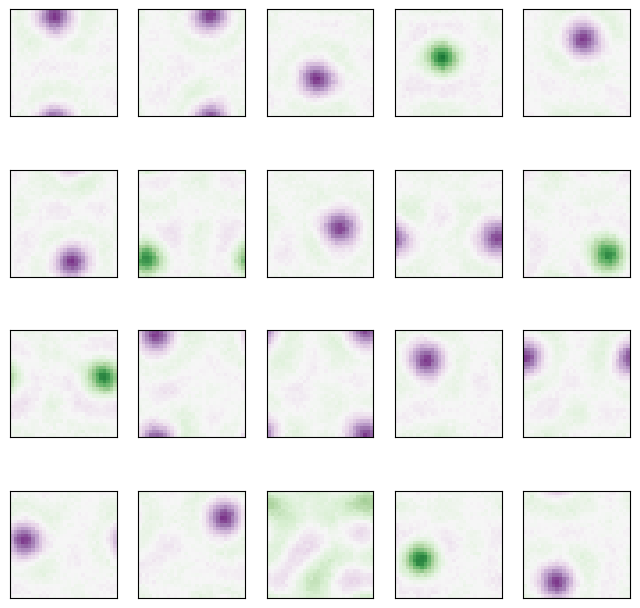

In [6]:
weights, metrics = simulate_or_load(**config)
w = weights[-1].reshape(-1, 30, 30)
fig, axs = plt.subplots(4, 5, figsize=(8,8))
m = jnp.max(jnp.abs(w))
for i, ax in enumerate(axs.flatten()):
    im = ax.imshow(w[i], cmap=cb.cbmap('cb.pregunta'), vmin=-m, vmax=m)
    ax.set_xticks([]); ax.set_yticks([])

In [8]:
# Let's pick a subset that doesn't wrap around so it looks prettier
ind = [2,3,4,5,7,9,13,16]
w_ = w[ind]
m = jnp.max(jnp.abs(w_))
for i, wi in enumerate(w_):
    im = plt.imshow(wi, cmap=cb.cbmap('cb.solstice'), vmin=-m, vmax=m)
    plt.xticks([]); plt.yticks([]); plt.axis('off')
    # cbar = plt.colorbar(im)
    plt.savefig(f'fig1/{i+1}-2d-blob.pdf', bbox_inches='tight')
    plt.close()

/var/folders/gq/3xlhh9496_j9xpjb7tkbqh280000gn/T/ipykernel_54286/3576419304.py:6: DeprecationWarning: cblind.cbmap is deprecated. Please use matplotlib.colormaps.get_cmap instead, or matplotlib.pyplot.get_cmap if you need to specify nbin (default is 256)
  im = plt.imshow(wi, cmap=cb.cbmap('cb.solstice'), vmin=-m, vmax=m)


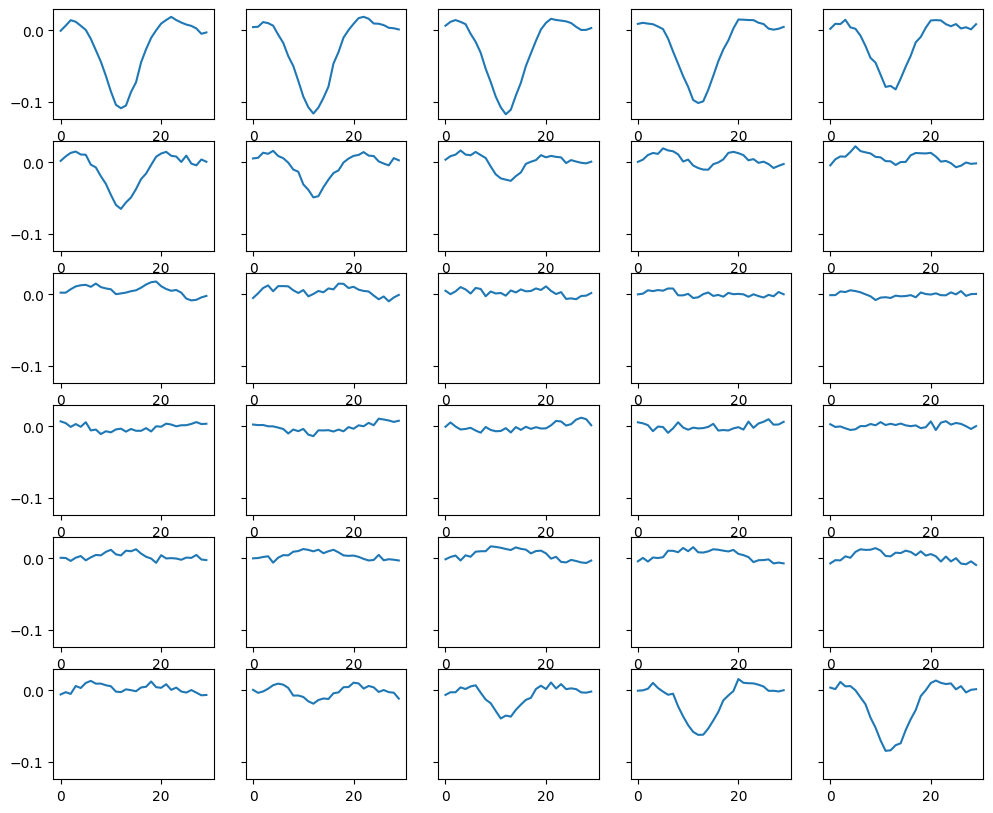

In [72]:
fig, axs = plt.subplots(6, 5, figsize=(12,10), sharey=True)
for i, ax in enumerate(axs.flatten()):
    ax.plot(w[0][i])